In [1]:
%load_ext lab_black

In [2]:
import requests

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("ggplot")


Bad key "text.kerning_factor" on line 4 in
/home/paul/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
import psycopg2

conn_string = "host='localhost' dbname='mev_inspect' user='postgres' password='password' port='6543'"
conn = psycopg2.connect(conn_string)

### Pull token reference data

In [11]:
token_ref = pd.DataFrame(
    requests.get("https://tokens.coingecko.com/uniswap/all.json").json()["tokens"]
)
token_ref.head()

token_ref_mapper = token_ref.set_index("address")["symbol"].to_dict()
token_decimals_mapper = token_ref.set_index("address")["decimals"].to_dict()

### Pull Block Data

In [4]:
df_blocks = pd.read_sql(
    """
    select 
    *
    from blocks
    """,
    conn,
)
df_blocks["block_timestamp"] = pd.to_datetime(df_blocks["block_timestamp"])

In [5]:
d = df_blocks.block_timestamp.max() - df_blocks.block_timestamp.min()
f"Data Spanning {d}"

'Data Spanning 0 days 18:38:00'

In [6]:
df_blocks.shape

(4769, 2)

### Pull Sandwich Data

In [12]:
df_sands = pd.read_sql("select * from sandwiches", conn)
df_sands["profit_token_symbol"] = df_sands.profit_token_address.map(token_ref_mapper)
df_sands["profit_token_decimals"] = df_sands.profit_token_address.map(
    token_decimals_mapper
)

df_sands["profit_amount"] = (
    df_sands["profit_amount"] / 10 ** df_sands["profit_token_decimals"]
)

In [35]:
df_sands.shape

(678, 12)

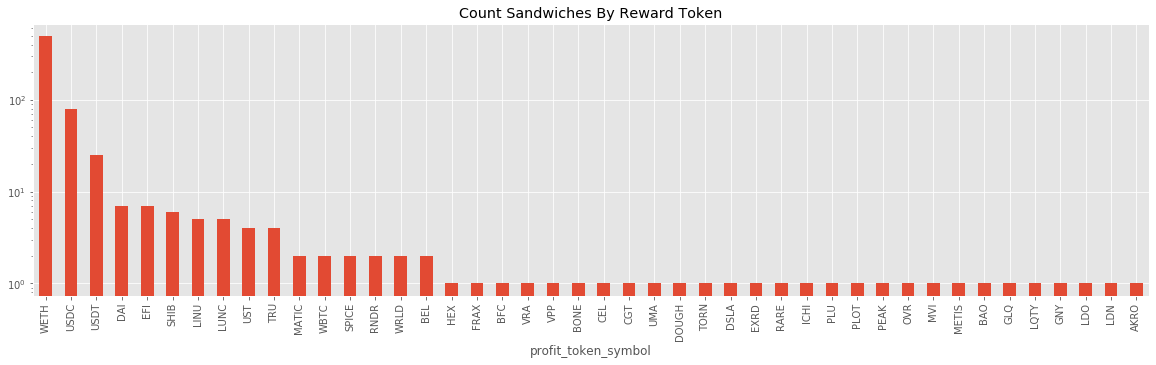

In [55]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_yscale("log")

(
    df_sands.groupby("profit_token_symbol")
    .size()
    .sort_values(ascending=False)
    .plot(kind="bar")
    .set_title("Count Sandwiches By Reward Token")
)
pass

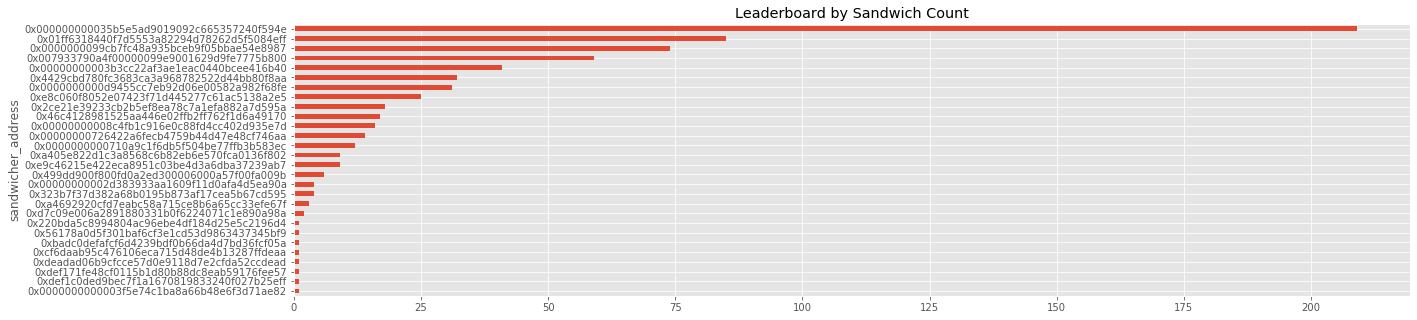

In [54]:
fig, ax = plt.subplots(figsize=(20, 5))
(
    df_sands.groupby("sandwicher_address")
    .size()
    .sort_values()
    .plot(kind="barh")
    .set_title("Leaderboard by Sandwich Count")
)
pass

/home/paul/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


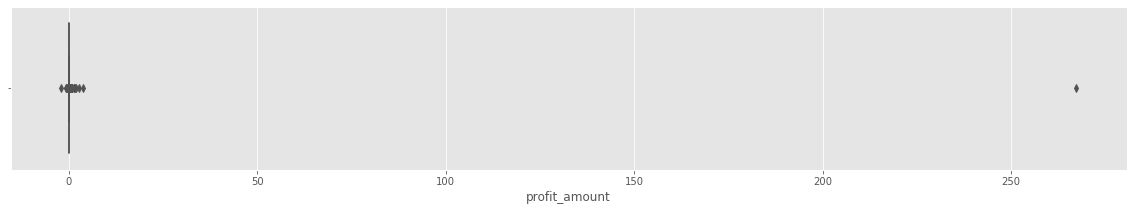

In [43]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.boxplot(df_sands[df_sands.profit_token_symbol == "WETH"].profit_amount)

In [51]:
sample = (
    df_sands[df_sands.profit_token_symbol == "WETH"]
    .sort_values("profit_amount", ascending=False)
    .iloc[0]
)

display(sample)

print("Front Hash: ", sample.frontrun_swap_transaction_hash)
print("Back Hash: ", sample.backrun_swap_transaction_hash)

id                                             2fe6571b-5c30-4a52-8a83-d8bc4f797ab6
created_at                                               2022-05-30 06:30:37.284704
block_number                                                             14871072.0
sandwicher_address                       0xbadc0defafcf6d4239bdf0b66da4d7bd36fcf05a
frontrun_swap_transaction_hash    0x89d02e99eaff0bef7068b37ba392172659324f34820d...
frontrun_swap_trace_address                                              [0, 11, 2]
backrun_swap_transaction_hash     0x90586946cf491f2ed4f426f3d34ad1d6ae6cf4418a21...
backrun_swap_trace_address                                       [0, 7, 2, 0, 1, 2]
profit_token_address                     0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
profit_amount                                                             267.22759
profit_token_symbol                                                            WETH
profit_token_decimals                                                       

Front Hash:  0x89d02e99eaff0bef7068b37ba392172659324f34820d7b64b4e109cef43ef55c
Back Hash:  0x90586946cf491f2ed4f426f3d34ad1d6ae6cf4418a213485e1bdfaedcb191971


/home/paul/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


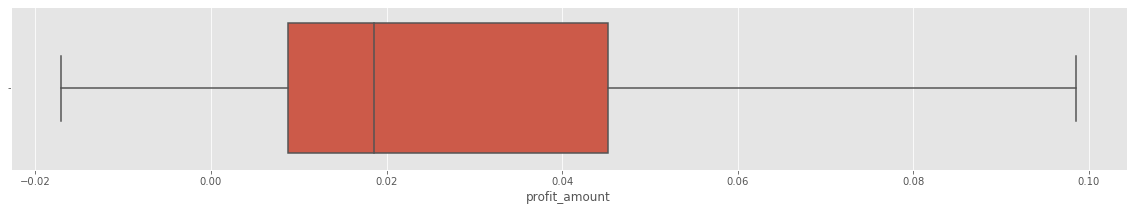

In [42]:
fig, ax = plt.subplots(figsize=(20, 3))
sns.boxplot(
    df_sands[df_sands.profit_token_symbol == "WETH"].profit_amount, showfliers=False
)